# 4. Multiple paths downhill

`Quagmire` allows the user to specify the number of downhill pathways to model flow in regions where diverging flow does not naturally fit the single-path-downhill view of the converging tributary view of stream flow. This also has some interesting effects on the numerical / discretisation errors.

```python
mesh.downhill_neighbours = 1
mesh.update_height(height)
```
where an integer specifies the number of downhill neighbour nodes (recipients) that will receive information of information from a donor node (1, 2 or 3 are usual, but the routine is general and will use second-nearest neighbours if they can be found at lower elevations). The `QuagMesh` object can also be initialised with:

```python
mesh = QuagMesh(DM, downhill_neighbours=1)
```

to specify the number of downhill neighbours (default is 2).

In this notebook we use a landscape function with many outflow points to examine the effect of varying the number of recipient nodes on catchment area, stream lengths, and outflow fluxes.

We also consider how expensive it is to use multiple path approaches.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from quagmire import tools as meshtools
%matplotlib inline

## Build a test mesh

We use a circular, triangulated domain with a height that represents a _crenulated sombrero_ topography. No noise is added - any irregularities are the result of discretisation.

In [2]:
from quagmire import QuagMesh 
from quagmire import QuagMesh # all routines we need are within this class
from quagmire import QuagMesh


minX, maxX = -5.0, 5.0
minY, maxY = -5.0, 5.0,

spacingX = 0.01
spacingY = 0.01

x, y, simplices = meshtools.elliptical_mesh(minX, maxX, minY, maxY, spacingX, spacingY, random_scale=1.0)
DM = meshtools.create_DMPlex(x, y, simplices)

mesh = QuagMesh(DM)

print( "\nNumber of points in the triangulation: {}".format(mesh.npoints))
print( "Downhill neighbour paths: {}".format(mesh.downhill_neighbours))

Underlying Mesh type: TriMesh
0 - Delaunay triangulation 0.7108418330000035s
0 - Calculate node weights and area 0.04893049999999732s
0 - Find boundaries 0.030858792000003632s
0 - cKDTree 0.033236875000000055s
0 - Construct neighbour cloud arrays 1.0653952910000015s, (0.7118491250000005s + 0.35350941699999794s)
0 - Construct rbf weights 0.09845241600000065s

Number of points in the triangulation: 250379
Downhill neighbour paths: 2


In [3]:
x = mesh.coords[:,0]
y = mesh.coords[:,1]
bmask = mesh.bmask

radius  = np.sqrt((x**2 + y**2))
theta   = np.arctan2(y,x) + 0.1

height  = np.exp(-0.025*(x**2 + y**2)**2) + 0.25 * (0.2*radius)**4  * np.cos(5.0*theta)**2 ## Less so
height  += 0.5 * (1.0-0.2*radius)

with mesh.deform_topography():
    mesh.downhill_neighbours = 2
    mesh.topography.data = height

rainfall_fn = mesh.topography ** 2.0

0 - Build downhill matrices 6.645978583999998s
0 - Build upstream areas 3.66539375s


In [4]:

colorby_1 = mesh.topography.evaluate(mesh)
colorby_2 = rainfall_fn.evaluate(mesh)

import k3d

plot = k3d.plot(grid_visible=False, lighting=0.75)
indices = mesh.tri.simplices.astype(np.uint32)
points  = np.column_stack([mesh.tri.points, height]).astype(np.float32)

plot += k3d.mesh(points+(00.0,0.0,0.0), indices, wireframe=False, flat_shading=True, side="double",
                    color_map = k3d.colormaps.paraview_color_maps.Gist_earth,
                    attribute=colorby_1,
                   )

plot += k3d.mesh(points+(15.0,0.0,0.0), indices, wireframe=False, flat_shading=True, side="double",
                    color_map = k3d.colormaps.matplotlib_color_maps.Blues,
                    attribute=colorby_2,
                   )

plot.display()




/Users/lmoresi/mambaforge/envs/underworld/lib/python3.9/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


Output()

In [5]:
mo1 = mesh.identify_outflow_points()
i = np.argsort(theta[mo1])
outflows = mo1[i]

## 1-2-3 downhill neighbours

In the case of 1 downhill neighbour, all of the water (information) from the parent node is given to a single recipient node. For more than one downhill neighbour, the water is partitioned based on the slope from the parent to recipient nodes.

From [Tucker *et al.* (2010)](http://doi.wiley.com/10.1002/esp.1952), the algorithm that controls this is:

$$
\frac{Q_i}{Q_{\mathrm{total}}} = \frac{S_i^{\alpha}}{\sum_{i=1}^{N} S_i^{\alpha}}
$$

where $\alpha = 0.5$.

In [6]:
flowpaths = mesh.upstream_integral_fn(rainfall_fn)

print("--- 2 downhill neighbours ---")
mesh.downhill_neighbours = 2
# mesh.update_height(height)

mo2 = mesh.identify_outflow_points()
flowpaths2 = flowpaths.evaluate(mesh)
outflow2   = flowpaths2[mo2]

# logpaths = np.log10(flowpaths)
# sqrtpaths = np.sqrt(flowpaths)

print("--- 3 downhill neighbour ---")
mesh.downhill_neighbours = 3
# mesh.update_height(height)

mo3 = mesh.identify_outflow_points()
flowpaths3 = flowpaths.evaluate(mesh)
outflow3   = flowpaths3[mo3]

# logpaths3 = np.log10(flowpaths3)
# sqrtpaths3 = np.sqrt(flowpaths3)

print("--- 1 downhill neighbour---")
mesh.downhill_neighbours = 1
# mesh.update_height(height)

mo1 = mesh.identify_outflow_points()
flowpaths1 = flowpaths.evaluate(mesh)
outflow1   = flowpaths1[mo1]


# logpaths1 = np.log10(flowpaths1)
# sqrtpaths1 = np.sqrt(flowpaths1)

--- 2 downhill neighbours ---
0 - Build downhill matrices 4.180064041000001s
0 - Build upstream areas 3.6466808340000014s
--- 3 downhill neighbour ---
0 - Build downhill matrices 6.225009833000001s
0 - Build upstream areas 3.9884087080000086s
--- 1 downhill neighbour---
0 - Build downhill matrices 1.8363700829999914s
0 - Build upstream areas 2.7617648749999972s


In [7]:

colorby_1 = flowpaths1
colorby_2 = flowpaths2
colorby_3 = flowpaths3


import k3d

plot = k3d.plot(grid_visible=False, lighting=0.75)
indices = mesh.tri.simplices.astype(np.uint32)
points  = np.column_stack([mesh.tri.points, height]).astype(np.float32)

plot += k3d.mesh(points+(00.0,0.0,0.0), indices, wireframe=False, flat_shading=True, side="double",
                    color_map = k3d.colormaps.matplotlib_color_maps.Blues,
                    attribute=colorby_1,
                    color_range = [0.0,1.0]
                   )

plot += k3d.mesh(points+(15.0,0.0,0.0), indices, wireframe=False, flat_shading=True, side="double",
                    color_map = k3d.colormaps.matplotlib_color_maps.Blues,
                    attribute=colorby_2,
                    color_range = [0.0,1.0]
                   )

plot += k3d.mesh(points+(30.0,0.0,0.0), indices, wireframe=False, flat_shading=True, side="double",
                    color_map = k3d.colormaps.matplotlib_color_maps.Blues,
                    attribute=colorby_3,
                    color_range = [0.0,1.0]
                   )

plot.display()





Output()

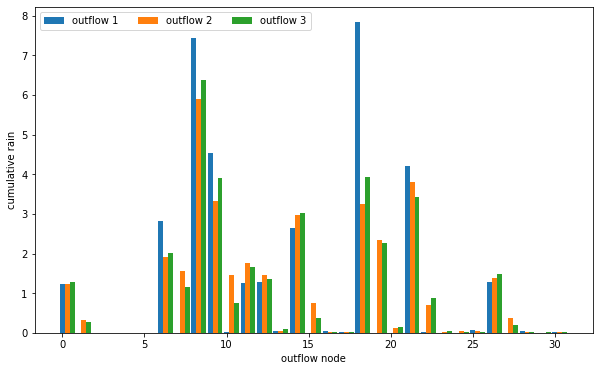

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline


# plot bar graph of cumulative rain for each outflow point

outflow_range = np.arange(0, len(outflow1))

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111, xlabel='outflow node', ylabel='cumulative rain')
ax1.bar(outflow_range, width=0.3, height=outflow1, label='outflow 1')
ax1.bar(outflow_range+0.3, width=0.3, height=outflow2, label='outflow 2')
ax1.bar(outflow_range+0.6, width=0.3, height=outflow3, label='outflow 3')

ax1.legend(ncol=3)
plt.show()

## Computational Efficiency

Compare metrics of the downhill matrix...

The number of nonzero elements in the matrix increases with more downhill neighbours as does the construction time. The difference in solution converges after 3 downhill neighbours.

In [9]:
flowpaths_fn = mesh.upstream_integral_fn(rainfall_fn)
flowpaths = flowpaths_fn.evaluate(mesh)
# storage vectors
nz = []
max_diff = []


max_downhill_neighbours = 10

for n in range(2, max_downhill_neighbours):
    flowpaths_old = flowpaths.copy()
    
    mesh.downhill_neighbours = n
    # mesh.update_height(height)
    downhillMat_info = mesh.downhillMat.getInfo()
    
    flowpaths = flowpaths_fn.evaluate(mesh)
    # flowpaths = mesh.streamwise_smoothing(flowpaths, 2)
    
    nz.append( downhillMat_info['nz_allocated'] )
    max_diff.append( np.abs(flowpaths - flowpaths_old).max() )

0 - Build downhill matrices 4.032934249999997s
0 - Build upstream areas 3.729282832999999s
0 - Build downhill matrices 6.1604346660000004s
0 - Build upstream areas 3.9158349579999907s
0 - Build downhill matrices 8.130687249999994s
0 - Build upstream areas 3.9265193750000122s
0 - Build downhill matrices 10.346841124999997s
0 - Build upstream areas 3.890271541000004s
0 - Build downhill matrices 12.299138290999991s
0 - Build upstream areas 3.757664458999983s
0 - Build downhill matrices 14.293661250000014s
0 - Build upstream areas 3.666082708999994s
0 - Build downhill matrices 16.39846591699998s
0 - Build upstream areas 3.6382929589999833s
0 - Build downhill matrices 18.495401041999997s
0 - Build upstream areas 3.6263284999999996s


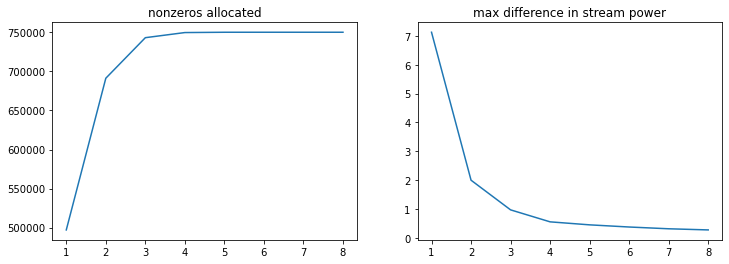

In [10]:
n_range = list(range(1, len(max_diff)+1))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

ax1.plot(n_range, nz)
ax1.set_title('nonzeros allocated')
ax2.plot(n_range, max_diff)
ax2.set_title('max difference in stream power')
plt.show()

## Dense downhill matrices

The cumulative flow routine can (potentially) be sped up by multiplying the downhill matrix $\mathbf{D}$ by itself, which increases the number of nodes a parcel of information is moved to its downhill neighbours. There is a tradeoff between the density of the matrix and the number of iterations and computational efficiency will depend on the way the underlying architecture optimises such problems.

$$
\mathbf{D}_N = \mathbf{I} + \mathbf{D} + \mathbf{D}^2 + \mathbf{D}^3 + \ldots + \mathbf{D}^N
$$

where $N$ is the length of the graph. This can be repeated any number of times and is only limited by the available system memory ($N=3$ is already a very dense matrix). In this section we examine tradeoff between density of the matrix and cumulative flow iterations.

We also need to note that it does not matter if we iterate too many times on the transport matrix as it has no effect once the graph is completely traversed. This means that we do not need to set $N$ to be a divisor of the length of the graph.

In [11]:
D1 = mesh.downhillMat
D2 = D1*D1
D4 = D2*D2
D8 = D4*D4

In [12]:
%%timeit 
D2 = D1*D1

116 ms ± 565 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
%%timeit
D4 = D2*D2

375 ms ± 4.09 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%%timeit
D8 = D4*D4

1.69 s ± 13.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
from timeit import default_timer as timer

its = []
nz = []
time = []

rainfall = rainfall_fn.evaluate(mesh)

for i, downMat in enumerate([D1, D2, D4, D8]):
    start = timer()
    downMatInfo = downMat.getInfo()
    
    mesh.downhillMat = downMat
    niter, flowpaths = mesh._cumulative_flow_verbose(mesh.area*rainfall)
    
    its.append(niter)
    nz.append(downMatInfo['nz_allocated'])
    time.append(timer()-start)

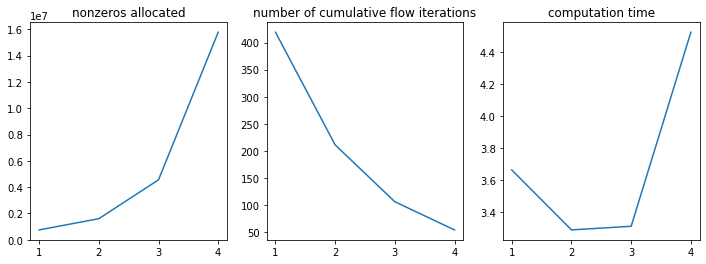

In [16]:
n_range = list(range(1, 5))

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))

ax1.plot(n_range, nz)
ax1.set_title('nonzeros allocated')
ax2.plot(n_range, its)
ax2.set_title('number of cumulative flow iterations')
ax3.plot(n_range, time)
ax3.set_title('computation time')


plt.show()

---

[Ex5-PreprocessingSurfaces](Ex5-PreprocessingSurfaces.md)